In [53]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from keras.models import Sequential
from keras import layers

from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

In [2]:
df_full = pd.read_csv('data.csv', index_col=0)
# label_cols = [c for c in df_full.columns if 'genre_' in c]
label_cols = ['genre_' + g for g in ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash']]
df_full['genre_other'] = (df_full[label_cols].sum(axis=1) == 0).astype(int)
label_cols.append('genre_other')
feature_cols_all = [c for c in df_full.columns if 'genre_' not in c]
genres = [c.replace('genre_', '') for c in label_cols]
print('genres: ', genres)

genres:  ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash', 'other']


In [3]:
words = set()
for label_col in label_cols:
    corr = df_full[feature_cols_all].apply(lambda x: x.corr(df_full[label_col]))
#     corr = corr[corr.abs().argsort()][len(corr) // 2:].sort_values()
    corr_words = corr.index[corr.abs() > 3 * corr.abs().mean()]
    words.update(set(corr_words))
feature_cols_r = sorted(words)

In [4]:
len(feature_cols_r), len(feature_cols_all)

(11505, 35258)

## Models

In [35]:
def keras_model(input_dim=None, n_nodes=(10,)):
    model = Sequential()
    model.add(layers.Dense(n_nodes[0], input_dim=input_dim, activation='relu'))
    for n in n_nodes[1:]:
        model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

rf_model = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0)

In [63]:
label = 'genre_black'
genre = label.replace('genre_', '')
print(genre)
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
X, y = df_norm[feature_cols_r].values, df_norm[label].values
n_nodes_search = [(n, m) for n in [32, 44, 56, 68] for m in [32, 44, 56, 68] if n > m]
scores = []
for n_nodes in n_nodes_search:
    model = KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=n_nodes, batch_size=2, epochs=8, verbose=False)
    score = cross_val_score(model, X, y, cv=5, n_jobs=-1)
    scores.append(score)
    print("{} ... {:.1f}% +/- {:.1f}%".format(n_nodes, score.mean() * 100, score.std() * 100))

black
(44, 32) ... 84.6% +/- 1.8%


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(56, 32) ... 84.5% +/- 3.5%


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(56, 44) ... 84.2% +/- 3.9%


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(68, 32) ... 83.8% +/- 2.4%


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(68, 44) ... 84.6% +/- 4.5%
(68, 56) ... 83.8% +/- 2.8%


In [64]:
label = 'genre_black'
genre = label.replace('genre_', '')
print(genre)
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
X, y = df_norm[feature_cols_r].values, df_norm[label].values
n_nodes = (40, 30)
model = KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=n_nodes, batch_size=2, epochs=8, verbose=False)
score = cross_val_score(model, X, y, cv=5, n_jobs=-1)
scores.append(score)
print("{} ... {:.1f}% +/- {:.1f}%".format(n_nodes, score.mean() * 100, score.std() * 100))

black
(40, 30) ... 85.4% +/- 3.6%


In [65]:
n_nodes = (40, 30)
print(n_nodes)
for label in label_cols:
    genre = label.replace('genre_', '')
    df_features = df_full[feature_cols_r]
    df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
    X, y = df_norm[feature_cols_r].values, df_norm[label].values
    model = KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=n_nodes, batch_size=2, epochs=8, verbose=False)
    score = cross_val_score(model, X, y, cv=5, n_jobs=-1)
    scores.append(score)
    print("{} ... {:.1f}% +/- {:.1f}%".format(genre, score.mean() * 100, score.std() * 100))

(40, 30)
black ... 82.8% +/- 4.4%
death ... 77.3% +/- 2.7%
doom ... 89.7% +/- 2.9%
folk ... 93.5% +/- 2.8%
heavy ... 89.4% +/- 2.2%
power ... 89.8% +/- 2.5%
progressive ... 90.0% +/- 3.0%
thrash ... 84.5% +/- 2.2%
other ... 92.6% +/- 2.2%


### Cross-validation score for different preprocessing techniques

In [6]:
genre = 'black'
model = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, min_samples_leaf=2, n_jobs=-1)
for reduce_features in [True, False]:
    print('Feature reduction: ', reduce_features)
    for normalize in [True, False]:
        print('Normalize: ', normalize)
        for sampler in [None, RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN]:
            X, y = df_to_Xy(df_full, genre, reduce_features=reduce_features, normalize=normalize, oversampler=sampler, logX=True, random_state=0)
            X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=True, test_size=0.2, random_state=0)
            cvscore = cross_val_score(model, X, y, cv=5)
            name = sampler.__name__ if sampler else 'No oversampling'
            print('{}: \t\t{:.4f} +/- {:.4f}'.format(name, cvscore.mean(), 2 * cvscore.std()))
        print()
    print('---')

Feature reduction:  True
Normalize:  True
No oversampling: 		0.7798 +/- 0.0958
RandomOverSampler: 		0.9164 +/- 0.0602
SMOTE: 		0.8782 +/- 0.1095
BorderlineSMOTE: 		0.8582 +/- 0.1101
SVMSMOTE: 		0.8945 +/- 0.0705
ADASYN: 		0.8689 +/- 0.1195

Normalize:  False
No oversampling: 		0.7850 +/- 0.0780
RandomOverSampler: 		0.9164 +/- 0.0506
SMOTE: 		0.8855 +/- 0.0924
BorderlineSMOTE: 		0.8600 +/- 0.1273
SVMSMOTE: 		0.8964 +/- 0.0469
ADASYN: 		0.8917 +/- 0.0731

---
Feature reduction:  False
Normalize:  True
No oversampling: 		0.7875 +/- 0.0783
RandomOverSampler: 		0.9218 +/- 0.0482
SMOTE: 		0.8673 +/- 0.1334
BorderlineSMOTE: 		0.8527 +/- 0.2010
SVMSMOTE: 		0.8836 +/- 0.0985
ADASYN: 		0.8674 +/- 0.1208

Normalize:  False
No oversampling: 		0.7876 +/- 0.1165
RandomOverSampler: 		0.9164 +/- 0.0436
SMOTE: 		0.8582 +/- 0.1645
BorderlineSMOTE: 		0.8691 +/- 0.1466
SVMSMOTE: 		0.8891 +/- 0.0722
ADASYN: 		0.8708 +/- 0.1405

---


In [7]:
genre = 'thrash'
model = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, min_samples_leaf=2, n_jobs=-1)
for reduce_features in [True, False]:
    print('Feature reduction: ', reduce_features)
    for normalize in [True, False]:
        print('Normalize: ', normalize)
        for sampler in [None, RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN]:
            X, y = df_to_Xy(df_full, genre, reduce_features=reduce_features, normalize=normalize, oversampler=sampler, logX=True, random_state=0)
            X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=True, test_size=0.2, random_state=0)
            cvscore = cross_val_score(model, X, y, cv=5)
            name = sampler.__name__ if sampler else 'No oversampling'
            print('{}: \t\t{:.4f} +/- {:.4f}'.format(name, cvscore.mean(), 2 * cvscore.std()))
        print()
    print('---')

Feature reduction:  True
Normalize:  True
No oversampling: 		0.8342 +/- 0.0193
RandomOverSampler: 		0.9922 +/- 0.0171
SMOTE: 		0.9121 +/- 0.2970
BorderlineSMOTE: 		0.9091 +/- 0.3091
SVMSMOTE: 		0.9229 +/- 0.2462
ADASYN: 		0.8998 +/- 0.3083

Normalize:  False
No oversampling: 		0.8342 +/- 0.0101
RandomOverSampler: 		0.9906 +/- 0.0117
SMOTE: 		0.9491 +/- 0.1505
BorderlineSMOTE: 		0.9492 +/- 0.1878
SVMSMOTE: 		0.9522 +/- 0.1450
ADASYN: 		0.9468 +/- 0.1738

---
Feature reduction:  False
Normalize:  True
No oversampling: 		0.8316 +/- 0.0017
RandomOverSampler: 		0.9938 +/- 0.0062
SMOTE: 		0.9106 +/- 0.3036
BorderlineSMOTE: 		0.9137 +/- 0.2987
SVMSMOTE: 		0.9199 +/- 0.2817
ADASYN: 		0.9199 +/- 0.2971

Normalize:  False
No oversampling: 		0.8342 +/- 0.0101
RandomOverSampler: 		0.9891 +/- 0.0125
SMOTE: 		0.9446 +/- 0.2139
BorderlineSMOTE: 		0.9430 +/- 0.2046
SVMSMOTE: 		0.9476 +/- 0.1789
ADASYN: 		0.9291 +/- 0.2450

---


### Cross-validation score for different genres

In [26]:
feature_cols = feature_cols_r
for label in label_cols:
    df_features = df_full[feature_cols]
    df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
    X, y = df_norm[feature_cols].values, df_norm[label].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
    model = rf_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cvscore = cross_val_score(model, X, y, cv=5)

    genre = label.replace('genre_', '')
    print(genre)
    print('CV score:              {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
    print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    # print('classification report:\n', classification_report(y_test, y_pred))
    print('confusion matrix:\n', confusion_matrix(y_test, y_pred))
    print('---')

black
CV score:              0.7857 +/- 0.0994
accuracy on test data: 0.8014
confusion matrix:
 [[90 17]
 [12 27]]
---
death
CV score:              0.7623 +/- 0.0598
accuracy on test data: 0.8014
confusion matrix:
 [[90  6]
 [23 27]]
---
doom
CV score:              0.8970 +/- 0.0007
accuracy on test data: 0.8767
confusion matrix:
 [[128   1]
 [ 17   0]]
---
folk
CV score:              0.9396 +/- 0.0049
accuracy on test data: 0.9247
confusion matrix:
 [[135   0]
 [ 11   0]]
---
heavy
CV score:              0.8984 +/- 0.0152
accuracy on test data: 0.9315
confusion matrix:
 [[131   0]
 [ 10   5]]
---
power
CV score:              0.8723 +/- 0.0059
accuracy on test data: 0.8973
confusion matrix:
 [[129   4]
 [ 11   2]]
---
progressive
CV score:              0.8997 +/- 0.0061
accuracy on test data: 0.9384
confusion matrix:
 [[137   0]
 [  9   0]]
---
thrash
CV score:              0.8324 +/- 0.0173
accuracy on test data: 0.8562
confusion matrix:
 [[121   1]
 [ 20   4]]
---
other
CV score:    

In [40]:
feature_cols = feature_cols_r
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for label in label_cols:
    genre = label.replace('genre_', '')
    print(genre)
    df_features = df_full[feature_cols]
    df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
    X, y = df_norm[feature_cols].values, df_norm[label].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
    model = keras_model()
    cvloss, cvscore = [], []
    for train_idx, valid_idx in folds.split(X_train, y_train):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_valid_cv = X_train[valid_idx]
        y_valid_cv = y_train[valid_idx]
        model.fit(X_train_cv, y_train_cv, epochs=30, verbose=False)
        cv_loss, cv_accuracy = model.evaluate(X_valid_cv, y_valid_cv)
        cvloss.append(cv_loss)
        cvscore.append(cv_accuracy)
    print('CV loss: {:.1f}% +/- {:.1f}%'.format(100 * np.mean(cvloss), 200 * np.std(cvloss)))
    print('CV score: {:.1f}% +/- {:.1f}%'.format(100 * np.mean(cvscore), 200 * np.std(cvscore)))
#     y_pred = model.predict(X_test)
#     print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
#     print('confusion matrix:\n', confusion_matrix(y_test, y_pred))
#     print('---')

black


KeyboardInterrupt: 

### Random forest grid search

In [60]:
X, y, feature_cols = df_to_Xy(df_full, 'death', reduce_features=False, normalize=True, oversampler=RandomOverSampler, logX=True)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=False, test_size=0.2)
# clf = RandomizedSearchCV(
#     estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
#     param_distributions={
#         'n_estimators': [10, 100, 100],
#         'max_features': ['auto', 'sqrt'],
#         'max_depth': [2, 5, 10, 20, 40, 80],
#         'min_samples_leaf': [1, 2, 4],
#         'min_samples_split': [2, 5, 10],
#         'bootstrap': [True, False]
#     },
#     n_iter=100,
#     cv=5,
#     n_jobs=-1,
#     random_state=0
# )
clf = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
    param_grid={
        'n_estimators': [100, 300, 1000],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [10, 30, 100],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2],
        'bootstrap': [True]
    },
    cv=5,
    n_jobs=-1
)
clf.fit(X_train, y_train)

bestimator = clf.best_estimator_
y_pred = bestimator.predict(X_test)
cvscore = cross_val_score(bestimator, X, y, cv=5)

print('Best estimator params:', clf.best_params_)
print('CV score:              {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

C:\Users\philippe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator params: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV score:              0.8711 +/- 0.0854
accuracy on test data: 0.8776
confusion matrix:
 [[38  8]
 [ 4 48]]


### Random forest best estimator

In [9]:
best_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [10]:
genre = 'black'
X, y, feature_cols = df_to_Xy(df_full, genre, reduce_features=feature_cols_r, normalize=True, oversampler=RandomOverSampler, logX=True)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=False, test_size=0.2)
model = RandomForestClassifier(n_jobs=-1, random_state=0, **best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cvscore = cross_val_score(model, X, y, cv=kfold)

print('cross-validation score: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on test data:  {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

cross-validation score: 0.9327 +/- 0.0145
accuracy on test data:  0.8636
confusion matrix:
 [[39  7]
 [ 8 56]]


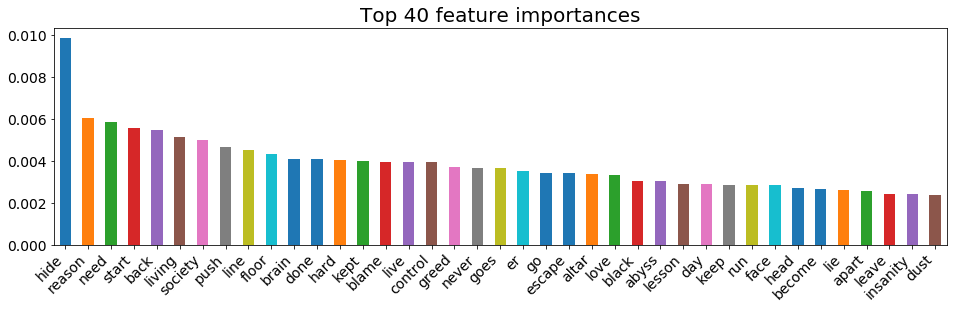

In [11]:
feature_importances = pd.Series(model.feature_importances_, index=feature_cols)
# std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
plt.figure(figsize=(16, 4))
feature_importances.sort_values()[:-40:-1].plot(kind='bar')
plt.title("Top 40 feature importances", size=20)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

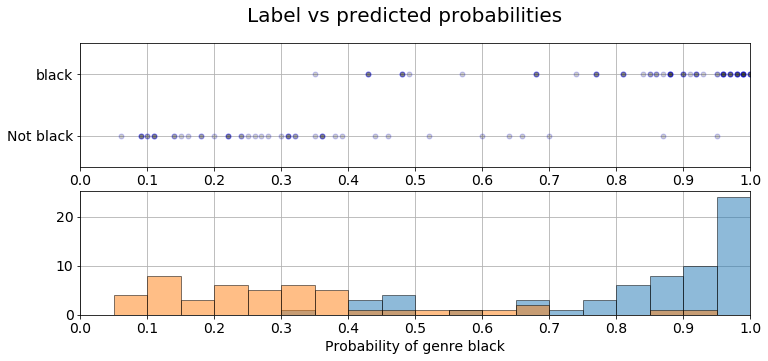

In [12]:
y_prob = model.predict_proba(X_test)[:, 1]
bins = np.linspace(0, 1, 21)
xticks = np.linspace(0, 1, 11)

plt.figure(figsize=(12, 5))
plt.suptitle("Label vs predicted probabilities", fontsize=20)
plt.subplot(2, 1, 1)
plt.plot(y_prob, y_test, 'o', markersize=5, markerfacecolor='none', markeredgecolor='b', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(-0.5, 1.5)
plt.tick_params(labelsize=14)
plt.xticks(xticks)
plt.yticks([0, 1], ["Not " + genre, genre])
plt.grid()
# plt.show()

# plt.figure(figsize=(12, 3))
plt.subplot(2, 1, 2)
plt.hist(y_prob[y_test == 1], bins=bins, alpha=0.5, edgecolor='k')
plt.hist(y_prob[y_test == 0], bins=bins, alpha=0.5, edgecolor='k')
plt.xlim(0, 1)
plt.tick_params(labelsize=14)
plt.xlabel("Probability of genre " + genre, fontsize=14)
plt.xticks(xticks)
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

# Neural network grid search

In [52]:
grid_results = {}
for label in label_cols:
    genre = label.replace('genre_', '')
    print(genre)
    df_features = df_full[feature_cols_r]
    df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
    X, y = df_norm[feature_cols_r].values, df_norm[label].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
    model = KerasClassifier(keras_model, epochs=32, verbose=False)
    param_grid = dict(batch_size=[2, 4, 8, 16, 32])
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_results[label] = grid.fit(X_train, y_train)

black


/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


death


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped 

doom


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of th

folk


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


heavy


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


power


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


progressive


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


thrash


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped 

other


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [57]:
for label in label_cols:
    print(label, grid_results[label].best_params_, "{:.4f}".format(grid_results[label].best_score_))

genre_black {'batch_size': 2} 0.8790
genre_death {'batch_size': 2} 0.7718
genre_doom {'batch_size': 2} 0.9771
genre_folk {'batch_size': 4} 0.9763
genre_heavy {'batch_size': 2} 0.9260
genre_power {'batch_size': 2} 0.9323
genre_progressive {'batch_size': 2} 0.9411
genre_thrash {'batch_size': 2} 0.8853
genre_other {'batch_size': 2} 0.9852


In [68]:
label = 'genre_black'
genre = label.replace('genre_', '')
print(genre)
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
X, y = df_norm[feature_cols_r].values, df_norm[label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
model = KerasClassifier(keras_model, input_dim=X.shape[1], n_nodes=n_nodes, verbose=False)
param_grid = dict(batch_size=[2, 4, 8, 16, 32], epochs=[16, 32, 64])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params: ", grid.best_params_)
print("Best score: {:.4f}".format(grid.best_score_))

black


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped 

Best params:  {'batch_size': 8, 'epochs': 64}
Best score: 0.8677


In [70]:
label = 'genre_folk'
genre = label.replace('genre_', '')
print(genre)
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
X, y = df_norm[feature_cols_r].values, df_norm[label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
model = KerasClassifier(keras_model, input_dim=X.shape[1], n_nodes=n_nodes, verbose=False)
param_grid = dict(batch_size=[2, 4, 8, 16, 32], epochs=[64])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params: ", grid.best_params_)
print("Best score: {:.4f}".format(grid.best_score_))

folk


/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/philippe/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped 

Best params:  {'batch_size': 4, 'epochs': 64}
Best score: 0.9502
